# Only use competicion data for both fine-tuning and final classification

Data used for fine-tuning and final classification :

* corpus completo 5 temas - 08-sep-2016 - codificacion 5 temas.csv (competition)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(52)

In [2]:
YEAR='2018'
DATA_PATH=Path('./DATA/'+YEAR)
# DATA_PATH=Path('./data/election_tweets')

WIKILM_PATH=Path('./WIKI_LM/LM')
PRE_FINETUNE_PATH=Path('./FINETUNE/'+YEAR)

TWEETSLM_PATH=Path('./TWEETS_LM/'+YEAR)
CLAS_PATH=Path('./TWEETS_CLAS/'+YEAR)

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

## Prepare Data

In [3]:
df_trn = pd.read_csv(DATA_PATH/'train.csv', header=None)
df_val = pd.read_csv(DATA_PATH/'validation.csv', header=None)
df_tst = pd.read_csv(DATA_PATH/'test.csv', header=None)
df_gen = pd.read_csv(DATA_PATH/'general.csv', header=None)

In [4]:
df_gen.head()

,0,1
0,3,"Salgo de #VeoTV , que día más largoooooo..."
1,2,@PauladeLasHeras No te libraras de ayudar me/n...
2,1,@marodriguezb Gracias MAR
3,0,"Off pensando en el regalito Sinde, la que se v..."
4,1,Conozco a alguien q es adicto al drama! Ja ja ...


In [5]:
tweets = np.concatenate([df_trn.values, df_trn.values, df_gen.values])
tweets_tst = np.concatenate([df_tst.values])
del df_trn, df_val, df_tst, df_gen

tweets[:5]

array([[1,
        'Sin ser fan de Juan Gabriel, siempre supe que era una fuerza de la naturaleza. Hoy escuché "Querida", y me dio una ternura enorme.'],
       [2,
        'ayer preguntaban y dónde están las solteras!!!! todo mi grupo alza la mano y yo la única que no y todas voltean a verme AJAJAJAJAJJA'],
       [2,
        'Que el finde sea para hacer cualquier cosa que a uno lo haga FELIZ, lo que sea pero que sea lo que a uno le de la reverenda gana'],
       [2,
        'Elige amar, así duela, así parezca un imposible, así te tiemble el alma, así tengas miedo, así vayas a salir herida. El amor transforma'],
       [0,
        'Hoy me sentí como grace de "al fondo hay sitio" cuando la atropellaron, solo que no fue de mentira y casi no la cuento que horrible']],
      dtype=object)

In [6]:
np.random.shuffle(tweets)
tweets[:5]

array([[1,
        'El Gobierno define el apoyo de CiU a sus recortes como "el inicio de una deseable colaboración" durante la legislatura @servimedia'],
       [0, '@RecuerdosPeru sus valores "procatolicos" no concuerdan con su evidente machismo'],
       [0, 'Curioso. Al de Amaiur no le han aplaudido ni los suyos'],
       [0,
        'Estomago perdón por las mariposas Almohada perdón por las lagrimas Corazón perdón por las lagrimas Cerebro, tenias razón'],
       [1,
        'Domingo y he visto amanecer! Precioso! Un beso Judith de mi corazón.... tú sabes!! y a los demás feliz domingo!']],
      dtype=object)

In [7]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

import unicodedata

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def preprocess_tweets(tweets):
    """
    twitter specific text processing and shuffle
    """
    # Remove \n
    tweets = np.array([str(i).replace('\n','') for i in tweets])
    tweets = np.array([str(i).replace('&lt;','') for i in tweets])
    tweets = np.array([str(i).replace('&gt;','') for i in tweets])
    
    # Remove accents
    tweets = np.array([strip_accents(i) for i in tweets])
    
    # Placeholders for hyperlinks and user references
    tweets = [['hyp_link' if i.startswith('http') 
               else 'hyp_link' if i.startswith('.http') 
               else 'user_ref' if i.startswith('@')
               else 'hash_tag' if i.startswith('#')
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for integers
    tweets = [[['int_string'] if isInt(i) 
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for slang
    tweets = [[['que'] if i in ['q', 'k', 'qu', 'ke', 'qe'] 
               else ['por'] if i=='x' 
               else ['porque'] if i in ['xq', 'pq', 'porq'] 
               else ['de'] if i=='d' 
               else ['te'] if i=='t'
               else ['también'] if i=='tb'
               else ['Que'] if i in ['Q', 'K', 'Qu','Ke', 'Qe'] 
               else ['Por'] if i=='X'
               else ['Porque'] if i in ['Xq', 'Pq', 'Porq'] 
               else ['De'] if i=='D' 
               else ['Te'] if i=='T'
               else ['También'] if i=='Tb'
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Lol type characters
    repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju'),
               ('risa_ja','aj'), ('risa_ji','ij'), ('risa_ju', 'uj'), ('risa_ja', 'lol')]

    # Adding prefix to lol type characters
    tweets = replace_lol(repl_str, tweets)

    return tweets


In [8]:
tweets[:,1] = preprocess_tweets(tweets[:,1])
tweets_tst[:,1] = preprocess_tweets(tweets_tst[:,1])

In [9]:
tweets[:5]

array([[1,
        'El Gobierno define el apoyo de CiU a sus recortes como "el inicio de una deseable colaboracion" durante la legislatura user_ref'],
       [0, 'user_ref sus valores "procatolicos" no concuerdan con su evidente machismo'],
       [0, 'Curioso. Al de Amaiur no le han aplaudido ni los suyos'],
       [0,
        'Estomago perdon por las mariposas Almohada perdon por las lagrimas Corazon perdon por las lagrimas Cerebro, tenias razon'],
       [1,
        'Domingo y he visto amanecer! Precioso! Un beso Judith de mi corazon.... tu sabes!! y a los demas feliz domingo!']],
      dtype=object)

In [10]:
tweets_tst[:5]

array([[nan, 'user_ref user_ref siempre hermosa maria gabriela'],
       [nan,
        'El sabado me dijeron "yo te he visto antes, pero no te he hablado porque... tu eres renegona, no? pero renegona FEO"'],
       [nan,
        'Sabes que no tendras un buen dia cuando lo primero que haces en la manana es tratar de cambiar un foco y este te cae en la cara'],
       [nan,
        'En situaciones en las que no sepas que hacer, sumergete en ti y solo asi podras escuchar lo que tu alma y tu corazon tienen que decir'],
       [nan,
        'El Universo es infinito y como tal quiere que tu tambien lo seas, no importa lo que suceda, en tus manos esta el poder de cambiarlo']],
      dtype=object)

In [11]:
# NEGA_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 0]
# POSI_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 1]
# NEUT_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 2]
# NONE_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 3]
# del tweets

# level_train_docs = [NEGA_train_docs,POSI_train_docs,NEUT_train_docs,NONE_train_docs]

# fmt = """Negative Sentences = {:d}
#        \rPositive Sentences = {:d}
#        \rNeutral  Sentences = {:d}
#        \rNone Values        = {:d}"""

# print(fmt.format(len(NEGA_train_docs),
#                  len(POSI_train_docs),
#                  len(NEUT_train_docs),
#                  len(NONE_train_docs)))

# maxSentLvl = max(len(POSI_train_docs),len(NEGA_train_docs),len(NEUT_train_docs),len(NONE_train_docs))

# print('Maximum number of sentences per level : ', maxSentLvl)


In [12]:
# from googletrans import Translator
# import random

# translator = Translator()
# tweets_bal = []
# for i in range(len(level_train_docs)):
#     level_per = np.array(random.sample(level_train_docs[i],maxSentLvl-len(level_train_docs[i])))
#     tweets_bal.append(level_per[:minSentLvl])
    
# print("New size of sentences:\n")
# fmt = """Negative Sentences = {:d}
#        \rPositive Sentences = {:d}
#        \rNeutral  Sentences = {:d}
#        \rNone Values        = {:d}"""

# print(fmt.format(len(tweets_bal[0]),
#                  len(tweets_bal[1]),
#                  len(tweets_bal[2]),
#                  len(tweets_bal[3])))

# # flat_tweets_bal = [item for sublist in tweets_bal for item in sublist]
# # shuf_tweets_bal = random.sample(flat_tweets_bal,len(flat_tweets_bal))

# # assert (len(shuf_tweets_bal) == 4 * minSentLvl)
# # print("shuf_tweets_bal size = ", len(shuf_tweets_bal))

# # shuf_tweets_bal = np.array(shuf_tweets_bal)
# # print(shuf_tweets_bal[:5])

In [11]:
col_names = ['label', 'tweet']

In [12]:
tweets_train, tweets_valid, labels_train, labels_valid = train_test_split(
                                                    tweets[:,1], tweets[:,0],
                                                    stratify=tweets[:,0], 
                                                    test_size=0.10)

# tweets_train, tweets_valid, labels_train, labels_valid = train_test_split(
#                                                     shuf_tweets_bal[:,1], shuf_tweets_bal[:,0],
#                                                     stratify=shuf_tweets_bal[:,0], 
#                                                     test_size=0.10)

print('train shapes:', tweets_train.shape, labels_train.shape)
print('valid shapes:', tweets_valid.shape, labels_valid.shape)
print('test shapes:', tweets_tst.shape)

train shapes: (8296,) (8296,)
valid shapes: (922,) (922,)
test shapes: (1428, 2)


In [13]:
df_trn = pd.DataFrame({'tweet':tweets_train, 'label':labels_train}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_valid, 'label':labels_valid}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets_tst[:,1], 'label':tweets_tst[:,0]}, columns=col_names)

In [14]:
print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

1    3011
0    2399
3    1984
2     902
Name: label, dtype: int64
1    335
0    267
3    220
2    100
Name: label, dtype: int64
Series([], Name: label, dtype: int64)


In [15]:
def balance_df(df):
    lst = [df]
    max_size = df['label'].value_counts().max()
    for class_index, group in df.groupby('label'):
        lst.append(group.sample(max_size-len(group), replace=True))
    df = pd.concat(lst)
    return df

df_trn = balance_df(df_trn)

print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

3    3011
2    3011
1    3011
0    3011
Name: label, dtype: int64
1    335
0    267
3    220
2    100
Name: label, dtype: int64
Series([], Name: label, dtype: int64)


In [16]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'validation.csv', header=False, index=False)
df_tst.to_csv(CLAS_PATH/'test.csv', header=False, index=False)
df_trn.shape, df_val.shape
# (CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in LABELS)

((12044, 2), (922, 2))

### Create dataframes for Language Model fine-tuning

In [17]:
tweets_lm = np.concatenate([tweets_train, tweets_valid, tweets_tst[:,1]])
labels_lm = np.concatenate([labels_train, labels_valid, [0]*len(tweets_tst[:,0])])

tweets_train_lm, tweets_valid_lm, labels_train_lm, labels_valid_lm = train_test_split(
                                                    tweets_lm, labels_lm,
                                                    stratify=labels_lm, 
                                                    test_size=0.10)

In [18]:
df_trn = pd.DataFrame({'tweet':tweets_train_lm, 'label':[0]*len(tweets_train_lm)}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_valid_lm, 'label':[0]*len(tweets_valid_lm)}, columns=col_names)

In [19]:
df_trn.to_csv(TWEETSLM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(TWEETSLM_PATH/'validation.csv', header=False, index=False)

In [20]:
df_trn.shape, df_val.shape

((9581, 2), (1065, 2))

## Tokenize and Standarize General Tokens


In [21]:
chunksize=24000

re1 = re.compile(r'  +')

In [22]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [23]:
df_trn = pd.read_csv(TWEETSLM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(TWEETSLM_PATH/'validation.csv', header=None, chunksize=chunksize)

In [24]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [25]:
len(tok_trn),len(trn_labels), len(tok_val), len(val_labels)

(9581, 9581, 1065, 1065)

In [26]:
print(tok_trn[:2])

[['\n', 'xbos', 'hoy', 'es', 'feriado', 'y', 'el', 'trafico', 'sera', 'menos', ',', 'igual', 'o', 'mayor', 'en', 'lima', ',', 'alla', 'vamos', 'con', 'fe'], ['\n', 'xbos', 'user_ref', 'youtuber', ',', 'escritor', 'y', 'dj', 'favorito', ',', 'que', 'me', 'inspira', 'y', 'admiro', 'mucho', ',', 'hoy', 'es', 'mi', 'cumpleanos', 'y', 'el', 'mejor', 'regalo', 'seria', 'que', 'me', 'saludes']]


In [27]:
(TWEETSLM_PATH/'tmp').mkdir(exist_ok=True)

In [28]:
np.save(TWEETSLM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(TWEETSLM_PATH/'tmp'/'tok_val.npy', tok_val)

In [29]:
tok_trn = np.load(TWEETSLM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(TWEETSLM_PATH/'tmp'/'tok_val.npy')

In [30]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('\n', 9581),
 ('xbos', 9581),
 ('de', 6884),
 ('.', 5139),
 ('user_ref', 5055),
 (',', 4674),
 ('que', 4596),
 ('la', 4368),
 ('el', 3944),
 ('y', 3609),
 ('a', 3586),
 ('en', 3528),
 ('!', 2760),
 ('hyp_link', 2295),
 ('no', 2120),
 ('hash_tag', 1949),
 ('"', 1757),
 ('t_up', 1647),
 ('los', 1572),
 ('un', 1506)]

In [31]:
max_vocab = 60000
min_freq = 1

In [32]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

8385

In [33]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [34]:
np.save(TWEETSLM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(TWEETSLM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'wb'))

## Load Encoder Weights for Language Model

In [35]:
BACKBONE_MODEL = PRE_FINETUNE_PATH/'models/lm1_wgts.h5'

In [36]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [37]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [38]:
itos2 = pickle.load((PRE_FINETUNE_PATH/'tmp'/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [39]:
em_sz,nh,nl = 400,1150,3

In [40]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))

In [41]:
vs=len(itos)
vs,len(trn_lm)

(8385, 9581)

In [42]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
n_replaced_vocab = 0

for i,w in enumerate(itos):
    r = stoi2[w]
    if r>=0 :
        new_w[i] = enc_wgts[r]
        n_replaced_vocab +=1
    else:
        new_w[i] = row_m

print(f'Reuse {n_replaced_vocab} word embeddings from fine-tuning')
print(f'{vs-n_replaced_vocab} where not in vocab from fine-tuning')

Reuse 4658 word embeddings from fine-tuning
3727 where not in vocab from fine-tuning


"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [43]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [44]:
wd=1e-7
bptt=70
bs=32
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [45]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [46]:
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(TWEETSLM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [47]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.8
# drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

In [48]:
learn = md.get_model(opt_fn, em_sz, nh, nl, dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [49]:
learn.model.load_state_dict(wgts)

 53%|█████▎    | 45/85 [01:14<01:04,  1.61s/it, loss=4.26]

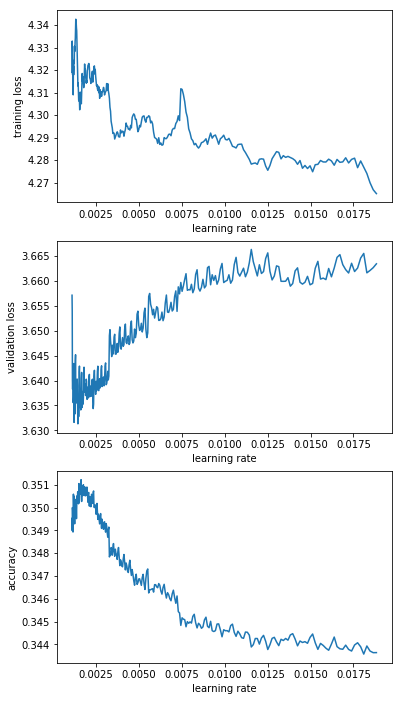

In [51]:
learn.lr_find2(start_lr=1e-3,end_lr=2e-2, num_it=300)
learn.sched.plot()

In [52]:
lr= 1e-3
lrs = lr

In [53]:
learn.clip=0.12

In [54]:
learn.fit(lr, 2, cycle_len=10, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy   
    0      4.259425   3.559835   0.360284  
    1      4.26       3.560366   0.360085  
    2      4.255407   3.55241    0.361507  
    3      4.257018   3.561902   0.360163  
    4      4.253008   3.561865   0.360842  
    5      4.250757   3.562956   0.361049  
    6      4.244962   3.563646   0.360589  
    7      4.243887   3.555523   0.361974  
    8      4.241183   3.561458   0.360438  
    9      4.2446     3.562961   0.360203  
    10     4.245107   3.563155   0.36048   
    11     4.237841   3.564662   0.360243  
    12     4.241578   3.558408   0.360983  
    13     4.237072   3.566251   0.359562  
    14     4.238369   3.566381   0.35908   
    15     4.232316   3.568843   0.359244  
    16     4.226723   3.569087   0.359677  
    17     4.234494   3.566752   0.359428  
    18     4.230861   3.566799   0.359402  
    19     4.232476   3.561523   0.360409  


[array([3.56152]), 0.36040900570943074]

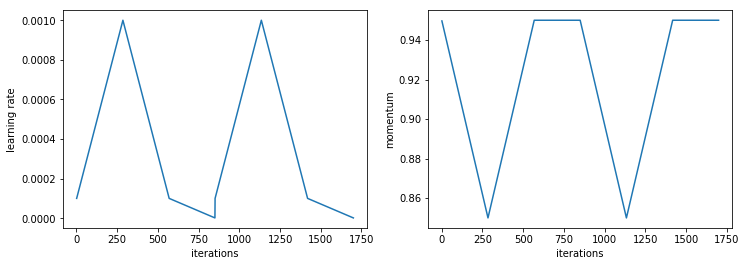

In [55]:
learn.sched.plot_lr()
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

## Classifier tokens

In [56]:
chunksize=24000

re1 = re.compile(r'  +')

In [57]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)
df_tst = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [58]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_tst, tst_labels = get_all(df_tst, 1)

In [59]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [60]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'tok_tst.npy', tok_tst)

In [61]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', tst_labels)

# df = pd.read_csv(CLAS_PATH/'test_labels.csv')
# df['label']=df['label'].replace(['N','P','NEU','NONE'],[0,1,2,3])
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', df['label'].values)

In [62]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_tst = np.load(CLAS_PATH/'tmp'/'tok_tst.npy')

In [63]:
itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

8385

In [64]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [65]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)
np.save(CLAS_PATH/'tmp'/'tst_ids.npy', tst_clas)

## Classifier

In [66]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [67]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [68]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 96

In [69]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1
print(c)

4


In the classifier, unlike LM, we need to read a tweet at a time. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie tweets, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [70]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TWEETSLM_PATH, trn_dl, val_dl, test_dl=val_dl)

In [71]:
#dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8
dps = np.array([0.4,0.5,0.05,0.3,0.4])

In [72]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1, layers=[em_sz*3, 50, c], drops=[dps[4], 0.1], dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [73]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [74]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [75]:
# wd = 1e-7
learn.load_encoder('lm1_enc')

In [76]:
learn.freeze_to(-1)

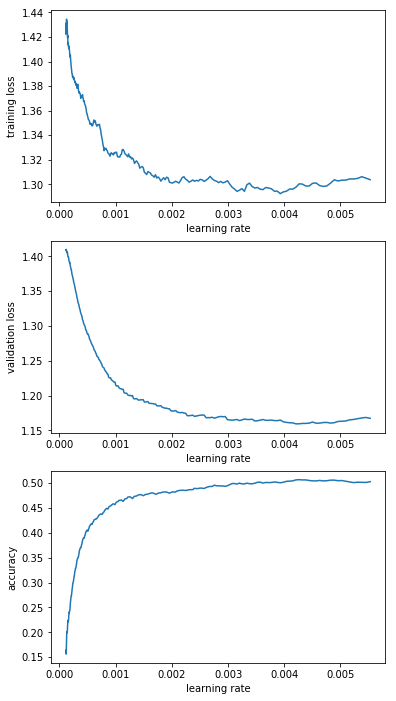

In [77]:
learn.lr_find2(start_lr=1e-4,end_lr=6e-3, num_it=300)
learn.sched.plot()

In [78]:
lr= 15e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [79]:
learn.fit(lrs, 5, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7), best_save_name='clas2_0')

epoch      trn_loss   val_loss   accuracy   
    0      1.28914    1.153725   0.53052   
    1      1.268853   1.12799    0.535916  
    2      1.258229   1.125665   0.537489  
    3      1.26819    1.116665   0.545548  
    4      1.250894   1.123195   0.534263  


[array([1.1232]), 0.5342627277782371]

In [80]:
learn.load('clas2_0')

In [81]:
learn.freeze_to(-2)

In [82]:
learn.fit(lrs, 10, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7),  best_save_name='clas2_1')

epoch      trn_loss   val_loss   accuracy   
    0      1.248642   1.111946   0.542146  
    1      1.235265   1.087083   0.541806  
    2      1.205531   1.066958   0.555823  
    3      1.197809   1.071128   0.552091  
    4      1.19652    1.06483    0.547904  
    5      1.182691   1.037551   0.57634   
    6      1.168286   1.050184   0.564608  
    7      1.148566   1.043414   0.572645  
    8      1.165654   1.037608   0.572808  
    9      1.122078   1.033329   0.572621  


[array([1.03333]), 0.5726205744184889]

In [83]:
learn.load('clas2_1')

In [84]:
learn.unfreeze()

In [85]:
learn.fit(lr, 2, cycle_len=5, use_clr_beta=(32,10,0.8,0.7), best_save_name='final')

epoch      trn_loss   val_loss   accuracy   
    0      1.152079   1.063886   0.544364  
    1      1.114403   1.020293   0.577653  
    2      0.888313   0.974592   0.627752  
    3      0.649206   0.948328   0.669513  
    4      0.479733   0.893547   0.703471  
    5      0.475936   1.033685   0.669759  
    6      0.523205   0.990853   0.701067  
    7      0.465385   1.043371   0.703894  
    8      0.303572   1.176937   0.70468   
    9      0.224416   1.200455   0.702687  


[array([1.20045]), 0.7026865251429446]

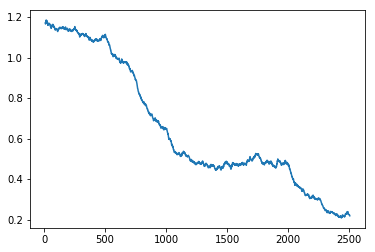

In [86]:
learn.load('final')
learn.sched.plot_loss()

## Model Evaluation

In [87]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [91]:
bs = 256
bptt,em_sz,nh,nl = 70,400,1150,3

tst_sent = np.load(CLAS_PATH/'tmp/tst_ids.npy')
tst_lbls = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()
# tst_lbls -= tst_lbls.min()
c=4 #int(tst_lbls.max())+1
tst_ds = TextDataset(tst_sent, tst_lbls)
tst_samp = SortSampler(tst_sent, key=lambda x: len(tst_sent[x]))
tst_lbls_sampled = tst_lbls[list(tst_samp)]
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=tst_samp)
md = ModelData(TWEETSLM_PATH, None, tst_dl)
itos = pickle.load(open(TWEETSLM_PATH/'tmp/itos.pkl', 'rb'))
vs = len(itos)

D:\opt\Anaconda3\envs\fastai_v07\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\opt\Anaconda3\envs\fastai_v07\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1(macro) =  0.0
Accuracy  =  0.0


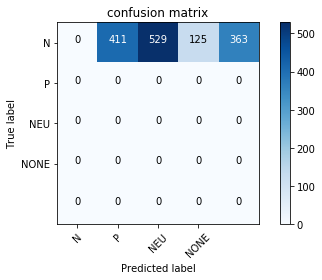

In [92]:
    
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1, layers=[em_sz*3, 50, c], drops=[0., 0.])

learn = RNN_Learner(md, TextModel(to_gpu(m)))
learn.load_encoder('lm1_enc')
learn.load('final')
predictions = np.argmax(learn.predict(), axis=1)

f1 = f1_score(tst_lbls_sampled, predictions, average='macro')
print('F1(macro) = ', f1)

acc = (tst_lbls_sampled == predictions).mean()
print('Accuracy  = ', acc)


cnf_matrix = confusion_matrix(tst_lbls_sampled, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'P', 'NEU', 'NONE'], title='confusion matrix')
plt.show()

In [94]:
def getLabel(num):
    if num == 0:
        return 'N'
    elif num == 1:
        return 'P'
    elif num == 2:
        return 'NEU'
    elif num == 3:
        return 'NONE'

In [95]:
import xml.etree.ElementTree as ET

def putTestValue(xmlFIle, out):
    tree = ET.parse(xmlFIle)
    root = tree.getroot()

    tweets = []
    file = open(out,"w") 
    print(file)
    print(len(predictions))
    for i,tweet in enumerate(root.iter('tweet')): 
        val = getLabel(predictions[list(tst_samp).index(i)])
        ID = tweet.find('tweetid').text
        #print(ID)
        file.write(ID + "\t" + val + "\n")
    file.close() 

In [96]:
# DATA_PATH = Path('D:/Maestria/NLP/AdvacedSentimentAnalysis/database/')
putTestValue(DATA_PATH/"task1-Test.xml", DATA_PATH/"output_ulmfit_2019.txt")

<_io.TextIOWrapper name='TWEETS_LM\\2018\\output_ulmfit_2018.txt' mode='w' encoding='cp1252'>
1428


In [97]:
print(TWEETSLM_PATH/"output_ulmfit_2018.txt")

TWEETS_LM\2018\output_ulmfit_2018.txt
